# Titanic Data Wrangling
The Titanic Survival Problem has become famous as a "toy" problem that illustrates important decisions about data for prediction tasks.  The survival problem is to create a predictive algorithm that can tell if an individual would have survived the titanic or not.  The principle is to use a data-driven approach to create the algorithm.  That is, use some of the survival data to create the algorithm and then use the remainder to test the algorithm.

This data is hosted at [kaggle](https://www.kaggle.com/c/titanic) and is used for tutorials of all kinds.  In this notebook we will focus almost exclusively on data wrangling to prepare the data for learning.

We are going to follow a multistep process.  

* First, we will look at the information we have for each passenger to understand what it tells us and to determine if it is useful.  We get the data in a spreadsheet format in which each row is a passenger and each column is a different type of data we know about that passenger (including whether or not that passenger survived).

* Next we will focus on trying to determine the quality of each type of data by looking at each column to see if it is related to survival or if the values are present for many of the passengers.  We will also look at relationships among the columns to see if they are correlated or not.

* Next we will look for inter-column relationships that can be used to define new columns with more predictive power that single columns.  We will also look for opportunities to group data within a column to provide classes of data with greater predictive power.

* Next we will make sure that all nominal variables have numerical codes.  This is important for a number of learning methods.

* Next we will drop the columns which we don't need.

* Next we will look at some techniques for "imputing" data points that are missing, but that we think might provide value.

* After imputation, we will revisit step 2 to see if there are correlations that show up with the richer data.  At this point we will use some useful visualizations to get a better intuition as to what the relationships in the data are.

* After acting on discoveries in the previous steps, we will perform some predictions to try to get an idea of what type of accuracy is possible.  We will use n-fold cross validation to help make our methods as robust and general as possible.

### The Passengers of the Titanic

Kaggle hosts [a description of the values in each column here](https://www.kaggle.com/c/titanic/data).  pandas will also give us some options for understanding the data.

In [453]:
import pandas as pd
datapath = "data/all/train.csv"
df = pd.read_csv(datapath)

# print column names
print(df.columns.values)

# look at the first 5 examples + column names
df.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [454]:
#print the data types and quantities in each column:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


With just a few methods, we can see alot about the data.  The `info` method in particular reveals important information about the types of data in each column, as well as the number of valid entries in each column.  

#### Data Types
We have numeric data in the columns `['PassengerId' 'Survived' 'Pclass' 'Age' 'SibSp' 'Parch' 'Fare']`

and nominal data in the columns `['Name' 'Sex' 'Ticket' 'Cabin' 'Embarked']`
 
We will look closer at the data types below.

#### Missing Data
There are 891 rows of data in total.  The output of `info()` reveals that there are three columns in which data is missing for some rows: `['Age' 'Cabin' 'Embarked']`

In [455]:
# `describe` reveals some statistics about our numeric columns.
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [456]:
# the 'O' option gives us some important info about nominal columns.
traindf.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Jarvis, Mr. John Denzil",male,1601,G6,S
freq,1,577,7,4,644


### Quality - What Data is Useful?
Now that we know something about the data, Let's start thinking about what to do to best use what we have.  Let's look at each column separately to assertain their suitability for classifying survival.  Below is a quick summary of results

| Column Name | Type | Keep? | Comments |
| --- | --- | --- | --- |
| PassengerID | numeric | N | A different value for each row.  Not useful for learning classifiers. |
| Survived | numeric | Y | This is the target value> |
| Pclass | numeric | Y | Class of travel will likely affect survival. |
| Name | nominal | N | There may be useful information here like title (Mr. Miss, Dr., etc.) |
| Sex | nominal | Y | Change this field to 1 = female, 0 = male. |
| Age | numeric | Y | Bin these values so that they are better for learning. Need to repair missing values. |
| SibSp | numeric | Y | Traveling with family likely affects survival. |
| Parch | numeric | Y | Traveling with family likely affects survival. |
| Ticket | nominal | N | Ticket numbers are inconsistent and don't lend themselves to patterns. |
| Fare | numeric | Y | Fare may affect survival. |
| Cabin | nominal | N | We don't know enough about cabin to us it well. |
| Embarked | nominal | Y | convert to a numeric value. |

Next let's remove the columns we know we won't use.

In [457]:
# remove columns we won't use
df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


#### Relationship to Survival
the seaborn visualization library gives us some nice tools for visualizing relationship between values in different fields.  We will use this tools for each remaining column to determine if we want to continue using it for inference.

In [458]:
# first things first:  pairwise correlation of the numeric fields in df
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


We will look only at the top two highly (absolute value) correlated items:

**Pclass and Fare** appear to be negatively correlated.  This makes sense because in general we would expact 1st class travel to be more expensive that 3rd class travel.

**Parch and SibSp** are positively correlated.  Apparently members of a family travel together often.

Notice that only numeric values show up here.  Later we will change nominal parameters to have nummeric values and rerun this analysis to them to the pairwise correlation matrix.

Next we will look at visualizing how columns compare to `Survived` values.

#### Pclass

In [459]:
# What is the sample likelihood of survival for different passenger classes
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


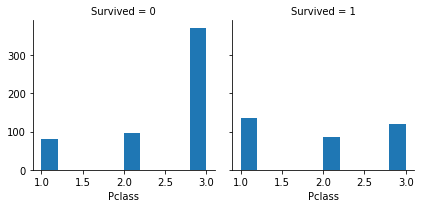

In [460]:
import seaborn as sns
import matplotlib.pyplot as plt

# what are the frequencies of Death and Survival given Passenger Class?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Pclass')

Pclass appears to be very much related to survival in this sample.

#### Age and AgeRange

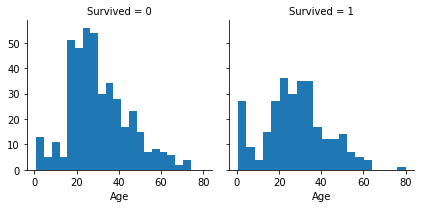

In [461]:
# what are the frequencies of Death and Survival given Age?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

It seems that Age has a strong affect on Survival.  Below we will use these histogram distributions to find good bin values for Age.  We will build bins around the ranges [0..17], [18..34], [35..49], [50..100].  

In [462]:
df['AgeRange'] = pd.cut(df['Age'], [0, 18, 35, 50,100], labels=[1, 2, 3, 4], include_lowest=True, right=True).astype(np.float)
df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeRange
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2.0
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q,NaN
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,4.0
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,1.0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,2.0
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,1.0


In [463]:
# What is the sample likelihood of survival for different Age Ranges
df[['AgeRange', 'Survived']].groupby(['AgeRange'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,AgeRange,Survived
0,1.0,0.503597
2,3.0,0.398693
1,2.0,0.382682
3,4.0,0.343750


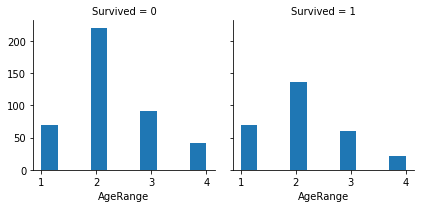

In [464]:
# what are the frequencies of Death and Survival given Age range?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'AgeRange')

It appears that young adults risk death on the titanic more than other categories of passengers.  Using `AgeRange`, we can see the afect of the values on survival:

In [465]:
# What is the sample likelihood of survival for different AgeRange?
df[['AgeRange', 'Survived']].groupby(['AgeRange'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,AgeRange,Survived
0,1.0,0.503597
2,3.0,0.398693
1,2.0,0.382682
3,4.0,0.343750


#### SibSp - Siblings and Spouses

In [466]:
# What is the sample likelihood of survival for different SibSp?
df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


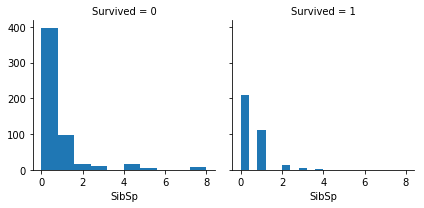

In [467]:
# what are the frequencies of Death and Survival given SibSp?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'SibSp')

One or two siblings or spouses seems to make survival more likely, but groups larger than 5 have no likelihood of survival.

#### Parch - Parent or Child

In [468]:
# What is the sample likelihood of survival for different Parch?
df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


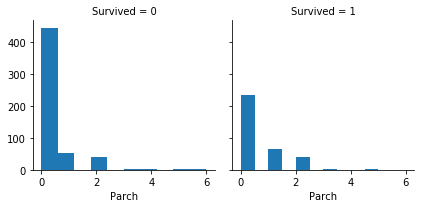

In [469]:
# what are the frequencies of Death and Survival given Parch?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Parch')

Again, small groups traveling together seem to have the best likelihood of survival.  

#### Fare and FareClass

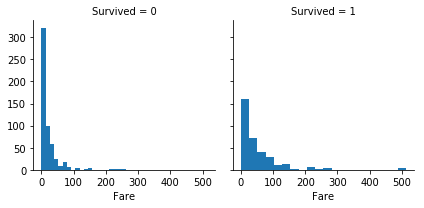

In [470]:
# what are the frequencies of Death and Survival given Fare?
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

It seems that lower fare indicates less chance of survival.  We will use this information to find a new variable related to `Fare` and `Pclass`.

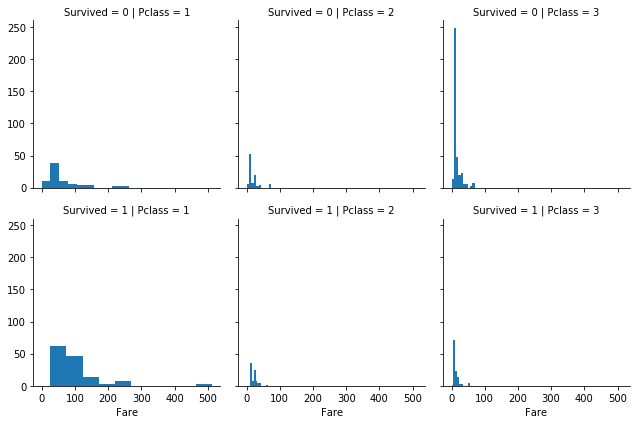

In [471]:
g = sns.FacetGrid(df, col='Pclass', row='Survived')
g.map(plt.hist, 'Fare', )

In [472]:
# Bin the Fare into a FareClass column
df['FareClass'] = pd.cut(df['Fare'], [0, 50, 150, 275,1000], labels=[1, 2, 3, 4], include_lowest=True, right=True).astype(np.int8)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeRange,FareClass
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2.0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2.0,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2.0,1


In [473]:
# What is the sample likelihood of survival for different Parch?
df[['FareClass', 'Survived']].groupby(['FareClass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FareClass,Survived
3,4,1.000000
1,2,0.679389
2,3,0.653846
0,1,0.318741


#### Sex

In [474]:
# What is the sample likelihood of survival for different Sex?
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


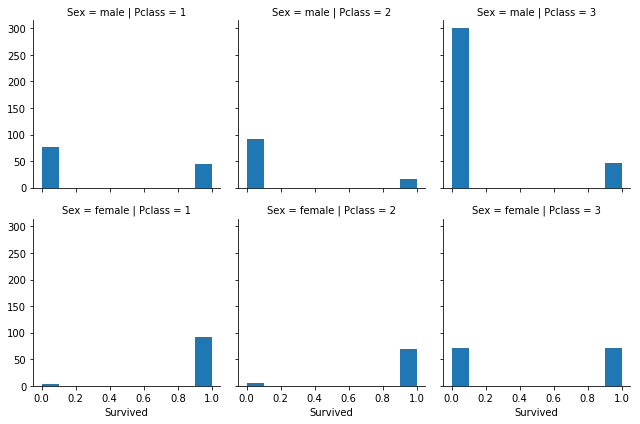

In [475]:
# what are the frequencies of Death and Survival given Sex and Pclass?
g = sns.FacetGrid(df, col='Pclass', row='Sex')
g.map(plt.hist, 'Survived')

Apparently sex has a very strong affect on survival.  If a passenger is female,  they already have a high likelihood of survival.  Also, if a passenger is male in passenger class 3, he is very likely to NOT survive.  Females in Pclass=3 are equally likely to survive or not, while females in other calsses have a high likelihood of survival.

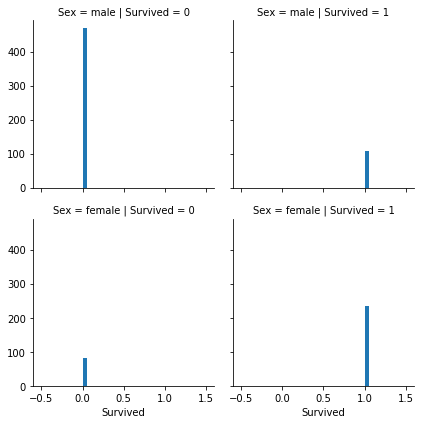

In [476]:
# what are the frequencies of Death and Survival given Fare?
g = sns.FacetGrid(df, col='Survived', row='Sex')
g.map(plt.hist, 'Survived', bins=20)

#### Embarked

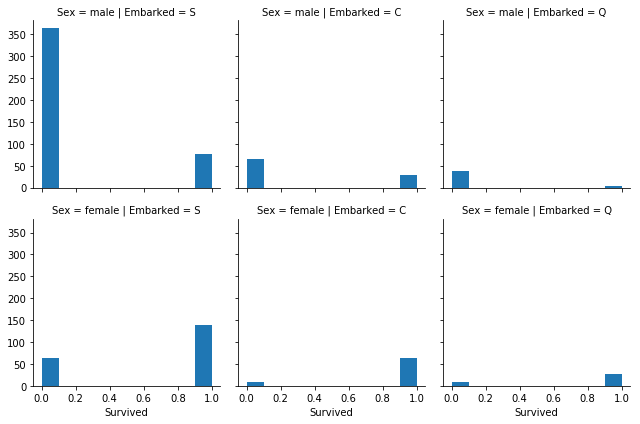

In [477]:
# How does Embarkation and Sex compare to Survival?
g = sns.FacetGrid(df, col='Embarked', row='Sex')
g.map(plt.hist, 'Survived')

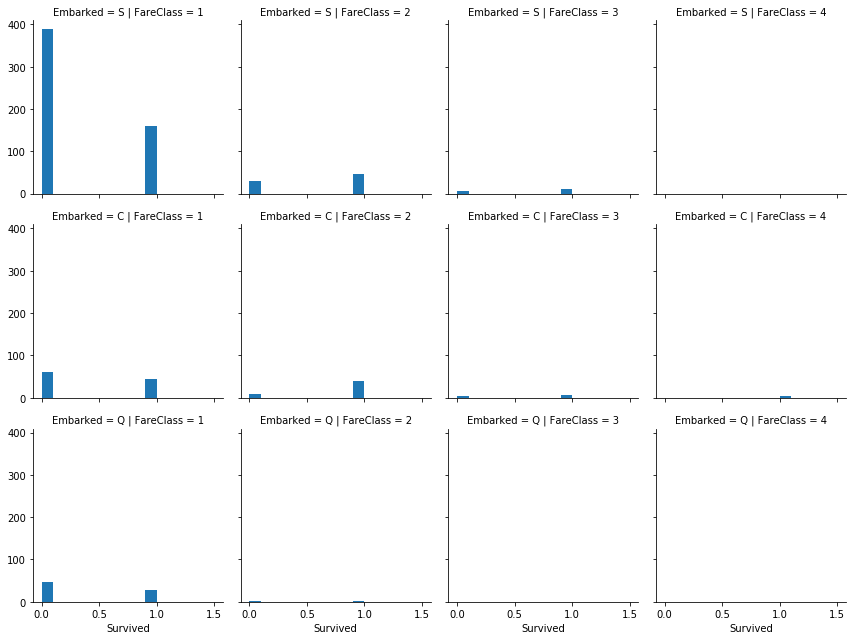

In [489]:
# How does Embarkation and FareClass compare to Survival?
g = sns.FacetGrid(df, col='FareClass', row='Embarked')
g.map(plt.hist, 'Survived')

It appears that Embarkation has a strong association with survival conditional on FareClass and Sex.

### Inter-Related Columns

Before we look closer to the data, Let's work on deriving some new feature columns that seem likely to help.  We will add the following new fields:

* A `Title` field derived from the `Name` column
* A Family size field derived from `SibSp` and `Parch`

Each of these changes requires us to use multiple columns to create and interpret the new field.

#### Extract `Title` from `Name`

In [479]:
# Extract title from name using the fact that titles end with period.
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# lets see if we have one for every row (there are 891 rows).
df['Title'].shape

(891,)

In [480]:
# how many different values are there?
# crosstab the result with the Sex column to see how they are realated
titles = pd.crosstab(df['Title'], df['Sex'])
print(titles.shape)
titles

(17, 2)


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Soon we will look at whether or not this field has any relationship with survival.  For the moment we will just hang onto this field. 

#### Create `FamilySize` from `Parch` and `SibSp`

In [481]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeRange,FareClass,Title,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2.0,1,Mr,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0,2,Mrs,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0,1,Miss,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2.0,2,Mrs,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2.0,1,Mr,1


In [482]:
# What is the sample likelihood of survival for different Family Sizes?
df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


### Numeric Fields

Now we want to do a few things to change the remaining nominal data to numeric codes.  This is helpful for a couple of the decision algorithms we might choose to use.  

* A numeric field called `Gender` to replace `Sex`
* A numeric field called `Depart` to replace `Embarked` 
* A numeric field for `Title`

In [483]:
import numpy as np
df['Gender'] = df['Sex'].map({'male':0, 'female':1}).astype(np.uint8)
df['Depart'] = df['Embarked'].map({'S':1, 'C':2, 'Q':3}, na_action='ignore').astype(np.float)
titleArr = df['Title'].unique()
mapping = {v: k for k, v in dict(enumerate(titleArr)).items()}
df['NamePrefix'] = df['Title'].map(mapping, na_action='ignore').astype(np.uint8)
df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeRange,FareClass,Title,FamilySize,Gender,Depart,NamePrefix
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2.0,1,Mr,2,0,1.0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0,2,Mrs,2,1,2.0,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0,1,Miss,1,1,1.0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2.0,2,Mrs,2,1,1.0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2.0,1,Mr,1,0,1.0,0
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q,NaN,1,Mr,1,0,3.0,0
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,4.0,2,Mr,1,0,1.0,0
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,1.0,1,Master,5,0,1.0,3
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,2.0,1,Mrs,3,1,1.0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,1.0,1,Mrs,2,1,2.0,1


### Drop Unneeded Columns
There are many columns that we have transformed now.  Let's remove them since we wont need them for training.

In [484]:
df1 = df.drop(['Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], axis=1)
df1.head(10)

,Survived,Pclass,AgeRange,FareClass,FamilySize,Gender,Depart,NamePrefix
0,0,3,2.0,1,2,0,1.0,0
1,1,1,3.0,2,2,1,2.0,1
2,1,3,2.0,1,1,1,1.0,2
3,1,1,2.0,2,2,1,1.0,1
4,0,3,2.0,1,1,0,1.0,0
5,0,3,NaN,1,1,0,3.0,0
6,0,1,4.0,2,1,0,1.0,0
7,0,3,1.0,1,5,0,1.0,3
8,1,3,2.0,1,3,1,1.0,1
9,1,2,1.0,1,2,1,2.0,1


### Impute Missing Values
Now that the columns are cleaner, lets make sure to fill in data that is missing so that we can use as many rows as possible.

In [485]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
AgeRange      714 non-null float64
FareClass     891 non-null int8
FamilySize    891 non-null int64
Gender        891 non-null uint8
Depart        889 non-null float64
NamePrefix    891 non-null uint8
dtypes: float64(2), int64(3), int8(1), uint8(2)
memory usage: 37.5 KB


There are two columns with missing data, `AgeRange` and `Depart`.  We are going to **impute**, or guess the missing values in these columns.  There are a number of ways to do this:

* Pick a value that seems reasonable.  Often the **median** value of the field is used in this case.
* Draw the value from a distribution.  Fix a distribution for the column's sample data and draw values from that distribution for the unknown values.  Typical distributions to use are categorical or normal.
* Find rows with known values that are close to values in the row with unknown column.  This is known as **K-Nearest Neighbor (KNN)** imputation.



In [486]:
import numpy as np
# code to support knn imputation
def euclidean_distance(a, b):
    c = a-b
    return np.sqrt(c.dot(c))

# test
row1 = df1.iloc[0]
row2 = df1.iloc[1]
print(euclidean_distance(row1, row2))
print(euclidean_distance(row1, row1))

# test
# apply euclidean distance to every pair of rows
# return the (dis)similarity matrix with the distances between each pair of rows
def distance_matrix(df, distance_measure = euclidean_distance):
    x = df1.drop(['Survived'], axis=1).fillna(0).values
    print(x.shape)
    m = np.matrix(np.zeros(shape=(x.shape[0],x.shape[0])))
    for i in range(x.shape[0]):
        for j in range(i, x.shape[0]):
            m[i,j] = euclidean_distance(x[i], x[j])
    return m + m.T

# m is the (dis)similarity matrix with the distances between each pair of rows
m = distance_matrix(df1)
#print(m[:10,:10])

# remove all indexes that are nan on the field we want
AgeRange_nan_indexes = df1[df1['AgeRange'].isnull()].index.values
#print(AgeRange_nan_indexes)
m1 = np.delete(m, AgeRange_nan_indexes, axis=0)
print(m1.shape)
#print(np.sort(m1[:,5])[:5,0])

def get_k_nn_indexes(m, df_row, k):
    idxs = np.argsort(m[:,df_row], axis = 0)
    return idxs[:k,0]

# test
#print('get_k_nn_indexes(m1, 5, 9)')
#print(get_k_nn_indexes(m1, 5, 9))

def get_k_nn_values(df, idxs, col):
    icol = df.columns.get_loc(col)
    return df.values[idxs, icol]

# test
idxs = get_k_nn_indexes(m1, 5, 15)
#print('get_k_nn_values(df1, idxs, "AgeRange")')
#print(get_k_nn_values(df1, idxs, 'AgeRange'))

# select the most common value for the missing data among the top k samples
def select_best(knns):
    dfknn = pd.DataFrame(knns, columns=['values'])
    return dfknn['values'].value_counts().index[0]  # pick the top count of knns

# test
knns = get_k_nn_values(df1, idxs, 'AgeRange')
#print('select_best(knns)')
#print(select_best(knns))

# replace nan values in a dataframe
def replace_value(df, col, indexes, values):
    d = dict(zip(indexes, values))
    return df[col].fillna(d)

# test
# impute nans for a column
values = []
for idx in AgeRange_nan_indexes:
    impute_idxs = get_k_nn_indexes(m1, idx, 7)
    knns = get_k_nn_values(df1, impute_idxs, 'AgeRange')
    best = select_best(knns)
    values.append(best)
    
#print(values)
df2 = df1
df2['AgeRange'] = replace_value(df1, 'AgeRange', AgeRange_nan_indexes, values)
df2.info()
#df2[df2.isnull()].shape
df2

def impute_knn(m, df, column, nan_indexes, k):
    values = []
    for idx in nan_indexes:
        impute_idxs = get_k_nn_indexes(m, idx, k)
        knns = get_k_nn_values(df, impute_idxs, column)
        best = select_best(knns)
        values.append(best)
    return values

#test
Depart_nan_indexes = df1[df1['Depart'].isnull()].index.values
v = impute_knn(m1, df1, 'Depart', Depart_nan_indexes ,11)
df2['Depart'] = replace_value(df1, 'Depart', Depart_nan_indexes, v)
df2.info()

3.1622776601683795
0.0
(891, 7)
[  5  17  19  26  28  29  31  32  36  42  45  46  47  48  55  64  65  76
  77  82  87  95 101 107 109 121 126 128 140 154 158 159 166 168 176 180
 181 185 186 196 198 201 214 223 229 235 240 241 250 256 260 264 270 274
 277 284 295 298 300 301 303 304 306 324 330 334 335 347 351 354 358 359
 364 367 368 375 384 388 409 410 411 413 415 420 425 428 431 444 451 454
 457 459 464 466 468 470 475 481 485 490 495 497 502 507 511 517 522 524
 527 531 533 538 547 552 557 560 563 564 568 573 578 584 589 593 596 598
 601 602 611 612 613 629 633 639 643 648 650 653 656 667 669 674 680 692
 697 709 711 718 727 732 738 739 740 760 766 768 773 776 778 783 790 792
 793 815 825 826 828 832 837 839 846 849 859 863 868 878 888]
(714, 891)
[3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.

In [490]:
# To find the knn of a row, pick the column of m corresponding to a row with a missing value, 
#  sort the values of that vector ascending, then pick the top k values from the list.
#  Note that if the row index < k, you should pick k+1 rows and throw out the top value
#  since it will correspond to the row being selected.  Next pick the indexes of the top k 
#  values and get those rows from the dataframe.  Use the values in the columns in 
#  question to impute the missing values.
def impute_nans(df, cols, k=9):
    m = distance_matrix(df)
    for col in cols:
        # get the indexes to rows with nan entries in this column
        nan_indexes = df[df[col].isnull()].index.values
        #remove those rows from the m1 matrix
        m1 = np.delete(m, nan_indexes, axis=0)
        nan_values = impute_knn(m1, df, col, nan_indexes, k)
        df[col] = replace_value(df, col, nan_indexes, nan_values)
        
# test
impute_nans(df1, ['AgeRange', 'Depart'], k=11)
df1.head()

(891, 7)


,Survived,Pclass,AgeRange,FareClass,FamilySize,Gender,Depart,NamePrefix
0,0,3,2.0,1,2,0,1.0,0
1,1,1,3.0,2,2,1,2.0,1
2,1,3,2.0,1,1,1,1.0,2
3,1,1,2.0,2,2,1,1.0,1
4,0,3,2.0,1,1,0,1.0,0


### Visualizations
Now that we have cleaned up the data, we can look at the relationships of the data to survival again using some of the visualizations we've seen before.

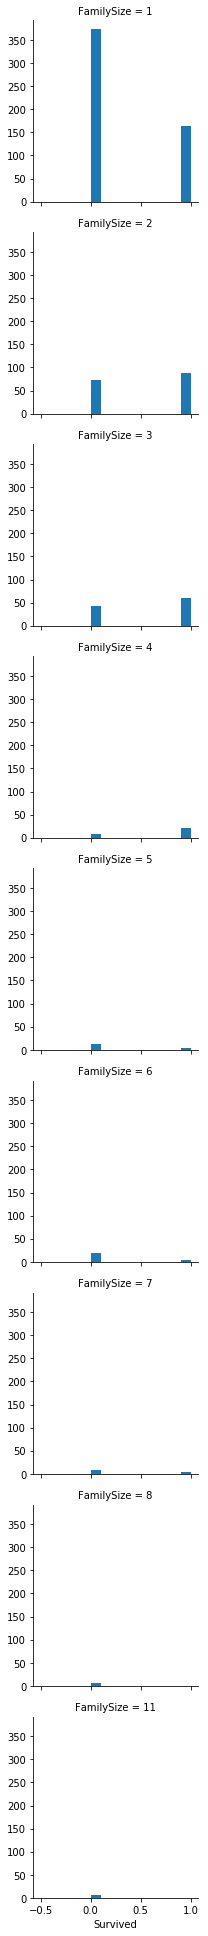

In [494]:
g = sns.FacetGrid(df, row='FamilySize')
g.map(plt.hist, 'Survived')

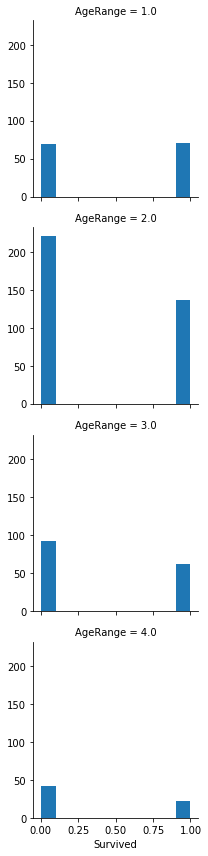

In [495]:
g = sns.FacetGrid(df, row='AgeRange')
g.map(plt.hist, 'Survived')

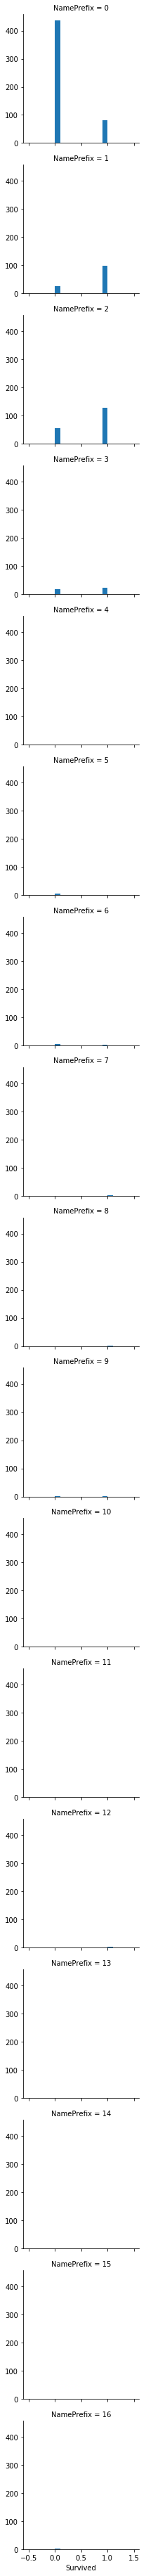

In [497]:
g = sns.FacetGrid(df, row='NamePrefix')
g.map(plt.hist, 'Survived')

`FamilySize`, `AgeRange`, and `NamePrefix` all have a number of values.  Some of these values correlate with survuival and some don't.  Sometimes the correlationis the result of very sparse data.  For example, `FamilySize = 11` correlates strongly with (non) survival.

In [498]:
# show a scattermatrix and a correlation matrix
df1.corr()

,Survived,Pclass,AgeRange,FareClass,FamilySize,Gender,Depart,NamePrefix
Survived,1.000000,-0.338481,-0.084406,0.270397,0.016639,0.543351,0.106811,0.290260
Pclass,-0.338481,1.000000,-0.286247,-0.583724,0.065997,-0.131900,0.045702,-0.191152
AgeRange,-0.084406,-0.286247,1.000000,0.110765,-0.221764,-0.122855,0.060356,-0.064718
FareClass,0.270397,-0.583724,0.110765,1.000000,0.168284,0.185719,0.037677,0.088005
FamilySize,0.016639,0.065997,-0.221764,0.168284,1.000000,0.200988,-0.080281,0.169749
Gender,0.543351,-0.131900,-0.122855,0.185719,0.200988,1.000000,0.116569,0.361165
Depart,0.106811,0.045702,0.060356,0.037677,-0.080281,0.116569,1.000000,0.087694
NamePrefix,0.290260,-0.191152,-0.064718,0.088005,0.169749,0.361165,0.087694,1.000000


The correlation matrix above shows the relationship between each pair of fields.  We will focus on correlations with `Survived`.  `Gender` has the strongest correlation.  Next is `Pclass` which is anti-correlated with `Survived`.  `NamePrefix` is slightly positively correlated with `Survived`. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f703080>,
      dtype=object)

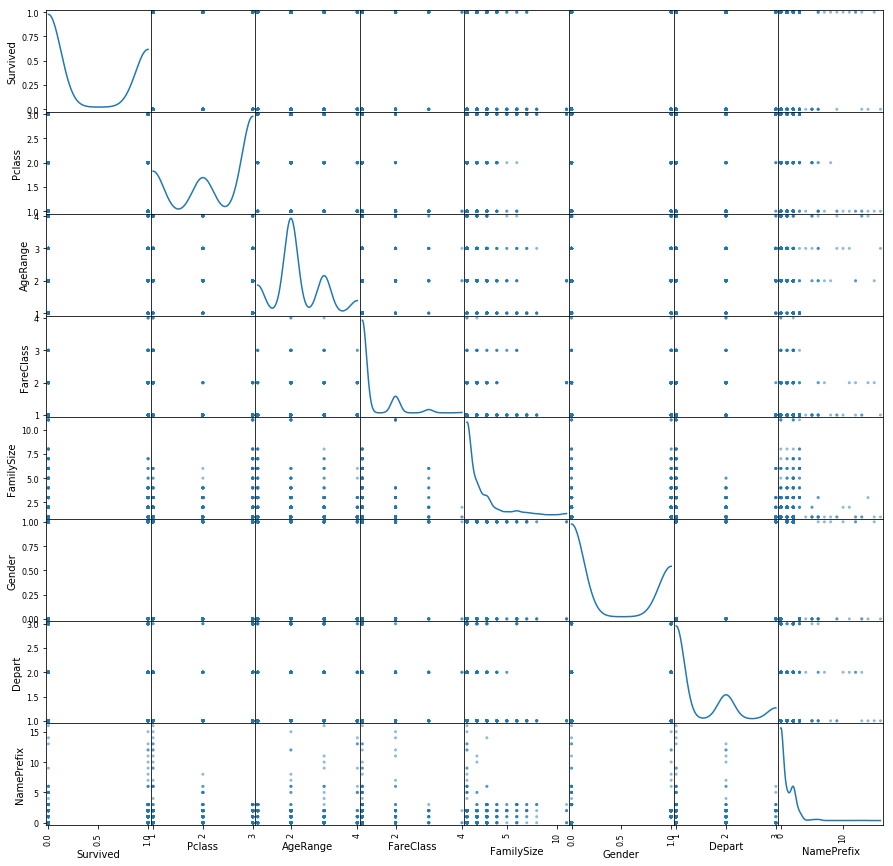

In [500]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(df1, figsize=(15,15), diagonal='kde')

The scatter matrix doesn't help us too much.  It is hard to see the results with the discrete value types.

### Learning from the Titanic

Now that we have data, lets see how good it is for prediction.  There are a few step to prepare for using this data for training.  
- Separate the data into training and test sets or design cross validation strategy
- Select an algorithm
- Train a model 
- Test the model

#### Separating Data Into Training and Testing


In [501]:
# train and test - we will use scikit-learn
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y,X = dmatrices('Survived ~ Pclass + AgeRange + FareClass + FamilySize + Gender + Depart + NamePrefix', 
                df1, return_type="dataframe")
y = np.ravel(y)

# in this case we hold out 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# create a logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)
model_lr.score(X_test, y_test) # check accuracy against the test data


0.7877094972067039

In [506]:
# Lets try Support Vector Machine.
from sklearn import svm

model_svc = svm.SVC(kernel='rbf', C=1)
model_svc.fit(X_train, y_train)
model_svc.score(X_test, y_test)

0.8100558659217877

In [507]:
# Now for a Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)

0.8268156424581006

Very nice result.  We can get more generalizable scores by looking at a boosted average of the test accuracy.  The most basic approach to this is to use cross validation.

#### Cross-Validation
Cross Validation is a way to provide robust accuracy scores when the quantity of data for training and testing is limited.  The idea is to split that data into a number of segments, then recombine the segments so that each segment is used as test data exactly once.  

So if we split the data into 3 segments and number them 1, 2, and 3, then we can combine to segments into training data and leave one for testing [[1,2],3].  Note that there are three different ways to do this; [[1,2],3], [[1,3],2],[1,[2,3]].  We train each of those and then test with the remaining segment.

This is done automatically using `cross_val_score`.

In [512]:
# logistic regression
scores_lm = cross_val_score(model_lr, X, y, cv=5)
print(scores_lm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lm.mean(), scores_lm.std() * 2))

[0.79329609 0.81005587 0.78651685 0.78651685 0.80225989]
Accuracy: 0.80 (+/- 0.02)


In [509]:
# Support vector machine
scores_svc = cross_val_score(model_svc, X, y, cv=5)
print(scores_svc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))

[0.84916201 0.82122905 0.80898876 0.80898876 0.83615819]
Accuracy: 0.82 (+/- 0.03)


In [510]:
# Random Forest
scores_rf = cross_val_score(model_rf, X, y, cv=5)
print(scores_rf)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

[0.77653631 0.78212291 0.84269663 0.76966292 0.82485876]
Accuracy: 0.80 (+/- 0.06)
